In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex2 import *

import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

<h2>Utility functions</h2>

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Utility functions from Tutorial
def make_mi_scores(X, y, descrete_features):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X_train, y_train,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()



/tmp/ipykernel_13/3017886777.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<h2>Reading the data and a look at the data structure</h2>

In [3]:
#Read data
# Read the data
X_full = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
X_test_full = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')
X_full_copy = X_full.copy()
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['Rings'], inplace=True)
y = X_full.Rings
X_full.drop(['Rings'], axis=1, inplace=True)

X_full.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975


In [4]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90615 entries, 0 to 90614
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.2+ MB


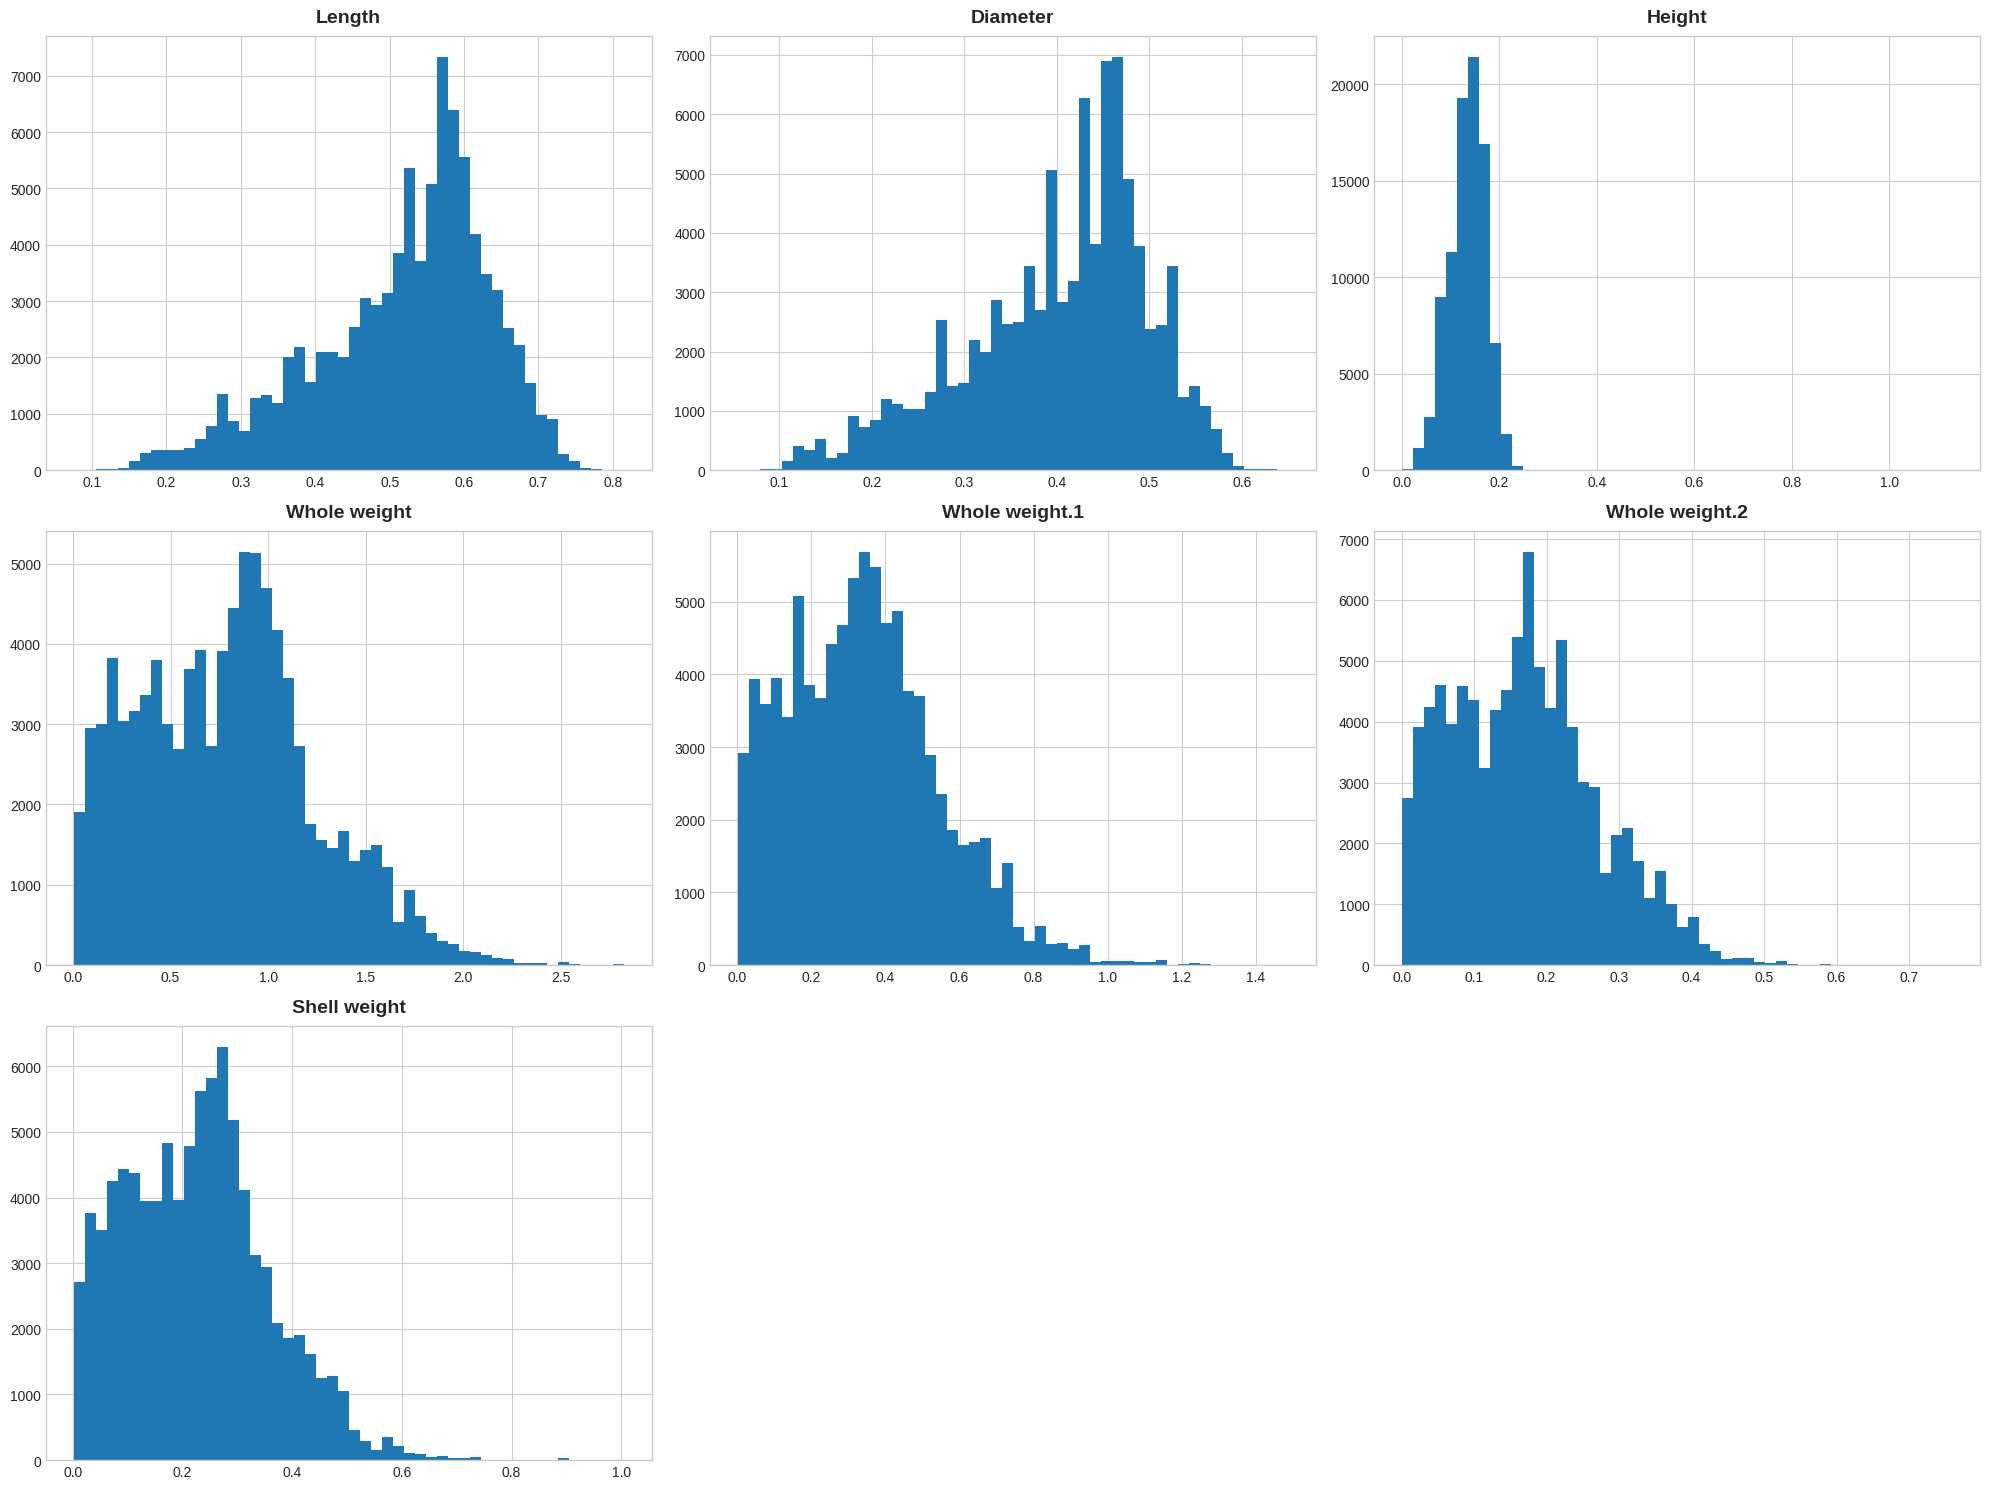

In [5]:
X_full.hist(bins=50, figsize=(20, 15))
plt.show()

<h3>Distrubution of target variable</h3>

<Axes: >

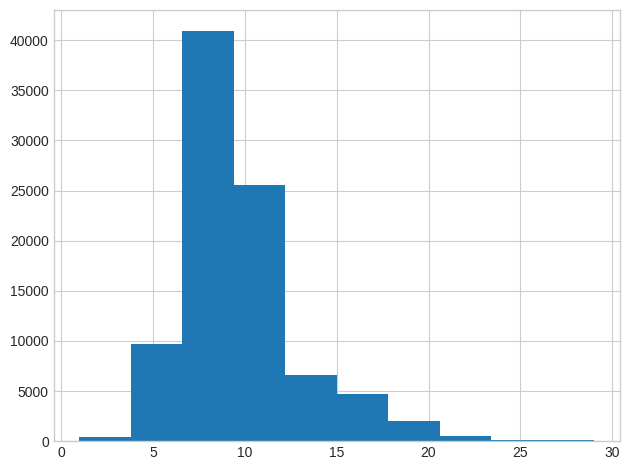

In [6]:
y.hist()

<h2>Feature engineering (No need extensive for data processing)</h2>

<h4>Check correlation</h4>

In [7]:
corr_matrix = X_full_copy.corr(numeric_only = True)
corr_matrix["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole weight      0.617274
Whole weight.2    0.588954
Whole weight.1    0.515067
Name: Rings, dtype: float64

<h4>MI scores</h4>

Shell weight      0.675040
Whole weight      0.573455
Height            0.550484
Whole weight.2    0.546286
Diameter          0.542881
Length            0.535933
Whole weight.1    0.509386
Sex               0.240992
Name: MI Scores, dtype: float64


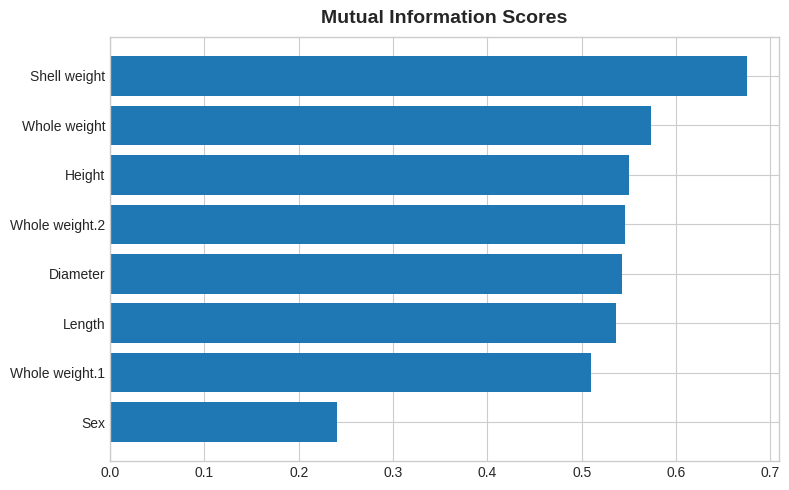

In [8]:
mi_scores = make_mi_scores(X_full, y, descrete_features=False)
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20 

<h4>Attribute combinations</h4>

In [9]:
# Loop through each feature and generate the lmplot
"""
for feature in features:
    sns.lmplot(
        x=feature, y="Rings", hue="Sex", col="Sex",
        data=X_full_copy, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4
    )
    plt.suptitle(f'Regression of {feature} on Rings by Sex', y=1.05)
    plt.show()
"""


'\nfor feature in features:\n    sns.lmplot(\n        x=feature, y="Rings", hue="Sex", col="Sex",\n        data=X_full_copy, scatter_kws={"edgecolor": \'w\'}, col_wrap=3, height=4\n    )\n    plt.suptitle(f\'Regression of {feature} on Rings by Sex\', y=1.05)\n    plt.show()\n'

<h4>Interaction feature between sex and whole weight</h4>

In [10]:

# Step 1: One-hot encode 'Sex' on the full training data (X_full)
X_full = pd.get_dummies(X_full, columns=['Sex'], drop_first=True)

# Step 2: One-hot encode 'Sex' on the full test data (X_test_full)
X_test_full = pd.get_dummies(X_test_full, columns=['Sex'], drop_first=True)

# Step 3: Create interaction terms on the training data (X_full)
X_full['Sex_M_WholeWeight_Interaction'] = X_full['Sex_M'] * X_full['Whole weight']
X_full['Sex_I_WholeWeight_Interaction'] = X_full['Sex_I'] * X_full['Whole weight']

# Step 4: Fit KMeans on the full training data (X_full)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X_full['Cluster'] = kmeans.fit_predict(X_full[['Whole weight', 'Sex_M', 'Sex_I']])

# Step 5: Create interaction terms on the test data (X_test_full) - using the same formula as for the training data
X_test_full['Sex_M_WholeWeight_Interaction'] = X_test_full['Sex_M'] * X_test_full['Whole weight']
X_test_full['Sex_I_WholeWeight_Interaction'] = X_test_full['Sex_I'] * X_test_full['Whole weight']

# Step 6: Apply the same KMeans model to the test data (X_test_full)
X_test_full['Cluster'] = kmeans.predict(X_test_full[['Whole weight', 'Sex_M', 'Sex_I']])
# Check the new dataframe with the interaction terms
print(X_full[['Sex_M', 'Sex_I', 'Whole weight', 'Sex_M_WholeWeight_Interaction', 'Sex_I_WholeWeight_Interaction']].head())


    Sex_M  Sex_I  Whole weight  Sex_M_WholeWeight_Interaction  \
id                                                              
0   False  False        0.7715                         0.0000   
1   False  False        1.1300                         0.0000   
2   False   True        0.0210                         0.0000   
3    True  False        0.9145                         0.9145   
4   False   True        0.7820                         0.0000   

    Sex_I_WholeWeight_Interaction  
id                                 
0                           0.000  
1                           0.000  
2                           0.021  
3                           0.000  
4                           0.782  


In [11]:
score_dataset(X_full, y)

0.15105693727743394

In [12]:
#Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

<h2>Fine tuning the XGBRegressor</h2>

In [13]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [4, 5],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

model = XGBRegressor(
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.1, 0.2], 'max_depth': [4, 5],
                         'min_child_weight': [1, 2], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

<h2>Train a model for the competion</h2>

In [14]:
# Create the pipeline
final_model = grid_search.best_estimator_
final_pipeline = Pipeline(steps=[
    ('preprocessor', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('model', final_model)
])


In [15]:
final_pipeline.fit(X_full, y)
# 2. Select numeric columns from the test data
test_preds = final_pipeline.predict(X_test_full)
# 3. Make predictions on the test data
# 4. Create the output DataFrame for submission
output = pd.DataFrame({'id': X_test_full.index, 
                       'Rings': test_preds})

# 5. Save the predictions to a CSV file for submission
output.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
